# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
### Load the images and plot them here.
import os
# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


In [2]:
training_file = '/Volumes/SSD/traffic-signs-data/train.p'
testing_file = '/Volumes/SSD/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

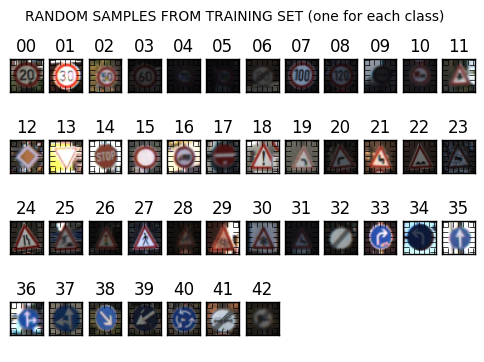

In [4]:
# show a random sample from each class of the traffic sign dataset
rows, cols = 4, 12
fig, ax_array = plt.subplots(rows, cols) # ax_array is a array object consistint of plt object
plt.suptitle('RANDOM SAMPLES FROM TRAINING SET (one for each class)')
for class_idx, ax in enumerate(ax_array.ravel()):
    if class_idx < n_classes:
        cur_X = X_train[y_train == class_idx]
        cur_img = cur_X[np.random.randint(len(cur_X))]
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(class_idx))
    else:
        ax.axis('off')
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)

plt.draw()

- We can also get the idea of how these classes are distributed in both training and testing set

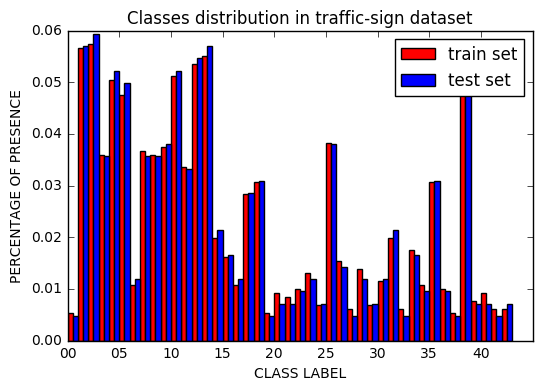

In [5]:
# bar chart of classes distribution
train_distribution, test_distribution = np.zeros(n_classes), np.zeros(n_classes)
for c in range(n_classes):
    train_distribution[c] = np.sum(y_train == c) / n_train
    test_distribution[c] = np.sum(y_test == c) / n_test
fig, ax = plt.subplots()
col_width = 0.5
bar_train = ax.bar(np.arange(n_classes), train_distribution, width=col_width, color='r')
bar_test = ax.bar(np.arange(n_classes)+col_width, test_distribution, width=col_width, color='b')
ax.set_ylabel('PERCENTAGE OF PRESENCE')
ax.set_xlabel('CLASS LABEL')
ax.set_title('Classes distribution in traffic-sign dataset')
ax.set_xticks(np.arange(0, n_classes, 5) )
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
ax.legend((bar_train[0], bar_test[0]), ('train set', 'test set'))
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
def preprocess_features(X, equalize_hist=True):
    # Convert from RGB to YUV
    X = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in X])
    
    # adjust image contrast
    if equalize_hist:
        X = np.array([np.expand_dims(cv2.equalizeHist(img), 2) for img in X])
        
    X = np.float32(X)
    
    # Standardize features
    X -= np.mean(X, axis=0)
    X /= (np.std(X, axis=0) + np.finfo('float32').eps)
    
    return X

In [7]:
X_train_norm = preprocess_features(X_train)
X_test_norm = preprocess_features(X_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I normalize the image by mean subtraction then divide it by its standard deviaction. There are lots of good reasons for doing this:

    1. Each image is converted from RGB to YUV color space, then only the Y channel is used.
    2. Pixel values often lie in the [0, 255] range. Feeding these values directly into a network may lead to numerical overflows. So each image is centered on zero mean and divided with its standard deviation.
    3. In the case of sigmoid activaction function, multiplying the weights with pixel values of large magnitudes will force the neuron to saturate. 

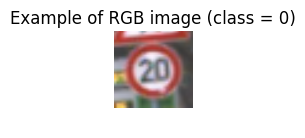

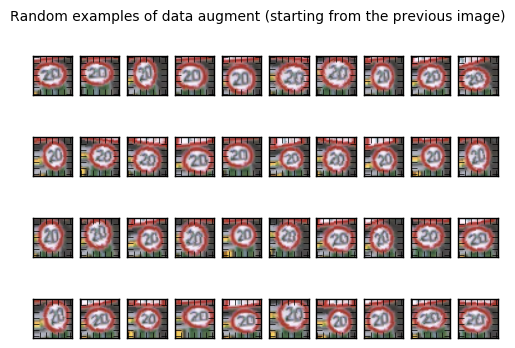

In [8]:
# creat the generator to perform online data augmentation
image_datagen = ImageDataGenerator(rotation_range=15.,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

# take a random image from the training set
img_rgb = X_train[10]

# plot the original image
plt.figure(figsize=(1,1))
plt.imshow(img_rgb)
plt.title('Example of RGB image (class = {})'.format(y_train[10]))
plt.axis('off')
plt.show()

# plot some randomly augmented images
rows, cols = 4, 10
fig, ax_array = plt.subplots(rows, cols)
for ax in ax_array.ravel():
    augmented_img, _ = image_datagen.flow(np.expand_dims(img_rgb, 0), y_train[10:11]).next()
    ax.imshow(np.uint8(np.squeeze(augmented_img)))
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.suptitle('Random examples of data augment (starting from the previous image)')
plt.show()

In [9]:
# split into training and test set
X_train, X_validation, y_train, y_validation = train_test_split(X_train_norm, y_train, test_size=0.2, random_state=0)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** sklearn.model_selection.train_test_split can easily split the total training data into train and validation dataset(test_size=0.2). I shuffle the total training data so that we donot have order bias. I generate additional data by randomly rotating the image a small angle(-10 to 10 degree). The only difference is the pixel rotation and the labels are the same.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

### Input
The LeNet architecture accepts a 32x32x3 image as input, where 3 is the number of color channels. 

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Relu.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Relu.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Relu.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Relu.

**Layer 5: Fully Connected (Logits).** This should have 43 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [10]:
n_classes = 43
def weight_variable(shape, mu=0, sigma=0.1):
    initialization = tf.truncated_normal(shape=shape, mean=mu, stddev=sigma)
    return tf.Variable(initialization)

def bias_variable(shape, start_val=0.1):
    initialization = tf.constant(start_val,shape=shape)
    return tf.Variable(initialization)

def conv2d(x, W, strides=[1,1,1,1], padding='SAME'):
    return tf.nn.conv2d(input=x, filter=W, strides=strides, padding=padding)

def max_pool2x2(x):
    return tf.nn.max_pool(value=x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

# network architecture definition
def my_net(x, n_classes):
    
    c1_out = 64
    conv1_W = weight_variable(shape=(3,3,1,c1_out))
    conv1_b = bias_variable(shape=(c1_out,))
    conv1 = tf.nn.relu(conv2d(x, conv1_W) + conv1_b)
    
    pool1 = max_pool2x2(conv1)
    
    drop1 = tf.nn.dropout(pool1, keep_prob=keep_prob)
    
    c2_out = 128
    conv2_W = weight_variable(shape=(3,3,c1_out, c2_out))
    conv2_b = bias_variable(shape=(c2_out,))
    conv2 = tf.nn.relu(conv2d(drop1, conv2_W) + conv2_b)
    
    pool2 = max_pool2x2(conv2)
    
    drop2 = tf.nn.dropout(pool2, keep_prob=keep_prob)
    
    fc0 = tf.concat([flatten(drop1), flatten(drop2)],1 )
    
    fc1_out = 64
    fc1_W = weight_variable(shape=(fc0._shape[1].value, fc1_out))
    fc1_b = bias_variable(shape=(fc1_out,))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    drop_fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    fc2_out = n_classes
    fc2_W = weight_variable(shape=(drop_fc1._shape[1].value, fc2_out))
    fc2_b = bias_variable(shape=(fc2_out,))
    logits = tf.matmul(drop_fc1, fc2_W) + fc2_b
    
    return logits

tf.reset_default_graph()
# placeholders
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32,1))
y = tf.placeholder(dtype=tf.int64, shape=None)
keep_prob = tf.placeholder(tf.float32)

# training pipeline
lr = 0.001
logits = my_net(x, n_classes=n_classes)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_function = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_operation = optimizer.minimize(loss=loss_function)

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), y)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
EPOCHS = 2
BATCHES_PER_EPOCH = 3
BATCH_SIZE = 128

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 

    Epoch:20

    optimizer: AdamOptimizer

    batch size: 128

    Learning rate: 0.001

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.
LeNet-5 is the convolutional network designed for handwritten and machine-printed character recognition. I think it is sutiable for the traffic sign classifier since both of them are image data with labels. Convolutional network takes into account the spatial information and improve the accurancy dramatically. Convolutional Neural Networks are designed to recognize visual patterns directly from pixel images with minimal preprocessing.  

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

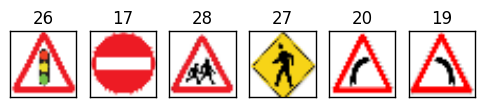

In [13]:
# load new images
new_images_dir = './extra traffic_signs'
new_test_images = [os.path.join(new_images_dir, f) for f in os.listdir(new_images_dir)]
new_test_images = [cv2.cvtColor(cv2.resize(cv2.imread(f), (32,32)), cv2.COLOR_BGR2RGB) for f in new_test_images]

# manually annotated labels for these new images
new_targets = [26, 17, 28, 27, 20, 19]

# plot new test images
fig, axarray = plt.subplots(1, len(new_test_images))
for i, ax in enumerate(axarray.ravel()):
    ax.imshow(new_test_images[i])
    ax.set_title('{}'.format(new_targets[i]))
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([]), ax.set_yticks([])

In [14]:
# first things first: feature preprocessing
new_test_images_norm = preprocess_features(new_test_images)

saver = tf.train.import_meta_graph('./checkpoints/traffic_sign_model.ckpt-1.meta')
with tf.Session() as sess:

    # restore saved session
    saver.restore(sess, './checkpoints/traffic_sign_model.ckpt-1')
#     new_saver.restore(sess, tf.train.latest_checkpoint('./'))
                  
    # predict on unseen images
    prediction = np.argmax(np.array(sess.run(logits, feed_dict={x: new_test_images_norm, keep_prob: 1.})), axis=1)

    accuracy = evaluate(new_test_images_norm, new_targets)
    
for i, pred in enumerate(prediction):
    print('Image {} - Target = {:02d}, Predicted = {:02d}'.format(i, new_targets[i], pred))
    
print('> Model accuracy: {:.02f}'.format(accuracy))

Image 0 - Target = 26, Predicted = 04
Image 1 - Target = 17, Predicted = 04
Image 2 - Target = 28, Predicted = 18
Image 3 - Target = 27, Predicted = 01
Image 4 - Target = 20, Predicted = 10
Image 5 - Target = 19, Predicted = 11
> Model accuracy: 0.00


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** 
1. The size of the image is different so I have to transfer it to 32x32x3. Then do the normalization.
2. Tensorflow x = tf.placeholder(tf.float32, (None, 32, 32, 3)), which expect the 4D input. I stack 6 images together to form (6, 32, 32, 3) tensor, then feed it into the tensorflow.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** The output from the prediction are: [26 17 28  2 20 37], in which 4 of them are correct and hence has accuracy of 66.7%. Obviously it is not as good as the result of test data, which has the accurance of 99.7%

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

Top 3 model predictions for image 0 (Target is 26)
   Prediction = 04 with confidence 0.43
   Prediction = 11 with confidence 0.14
   Prediction = 07 with confidence 0.09
Top 3 model predictions for image 1 (Target is 17)
   Prediction = 04 with confidence 0.60
   Prediction = 38 with confidence 0.12
   Prediction = 07 with confidence 0.09
Top 3 model predictions for image 2 (Target is 28)
   Prediction = 18 with confidence 0.19
   Prediction = 25 with confidence 0.18
   Prediction = 34 with confidence 0.13
Top 3 model predictions for image 3 (Target is 27)
   Prediction = 01 with confidence 0.93
   Prediction = 18 with confidence 0.03
   Prediction = 05 with confidence 0.01
Top 3 model predictions for image 4 (Target is 20)
   Prediction = 10 with confidence 0.20
   Prediction = 04 with confidence 0.20
   Prediction = 18 with confidence 0.14
Top 3 model predictions for image 5 (Target is 19)
   Prediction = 11 with confidence 0.26
   Prediction = 31 with confidence 0.11
   Prediction 

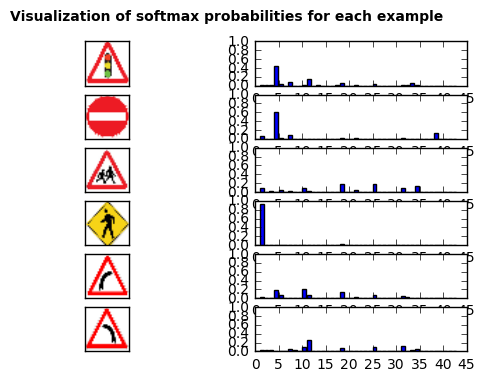

In [15]:
# visualizing softmax probabilities
with tf.Session() as sess:

    # restore saved session
    saver.restore(sess, './checkpoints/traffic_sign_model.ckpt-1')

    # certainty of predictions
    K = 3
    top_3 = sess.run(tf.nn.top_k(logits, k=K), feed_dict={x: new_test_images_norm, keep_prob: 1.})

    # compute softmax probabilities
    softmax_probs = sess.run(tf.nn.softmax(logits), feed_dict={x: new_test_images_norm, keep_prob: 1.})

# plot softmax probs along with traffic sign examples
n_images = new_test_images_norm.shape[0]
fig, axarray = plt.subplots(n_images, 2)
plt.suptitle('Visualization of softmax probabilities for each example', fontweight='bold')
for r in range(0, n_images):
    axarray[r, 0].imshow(np.squeeze(new_test_images[r]))
    axarray[r, 0].set_xticks([]), axarray[r, 0].set_yticks([])
    plt.setp(axarray[r, 0].get_xticklabels(), visible=False)
    plt.setp(axarray[r, 0].get_yticklabels(), visible=False)
    axarray[r, 1].bar(np.arange(n_classes), softmax_probs[r])
    axarray[r, 1].set_ylim([0, 1])
    
# print top K predictions of the model for each example, along with confidence (softmax score)    
for i in range(len(new_test_images)):
    print('Top {} model predictions for image {} (Target is {:02d})'.format(K, i, new_targets[i]))
    for k in range(K):
        top_c = top_3[1][i][k]
        print('   Prediction = {:02d} with confidence {:.2f}'.format(top_c, softmax_probs[i][top_c]))

**Answer:** The model is very certain about picture 1,2,3,4,6 and not very certain about picture 5. In the case of the sixth prediction, the correct answer is at the third largest possibility.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.